In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from utils.attacker import attackDatasetEditDist,changeRandomCharacters
import pandas as pd
import deepmatcher as dm
import numpy as np
from utils.deepmatcher_utils import wrapDm,getF1PrecisionRecall,getMeanConfidenceAndVariance,getTruePositiveNegative
from tqdm import tqdm
from sklearn.utils import shuffle
from collections import OrderedDict

In [4]:
##given a perturbation model and number of perturbation calculate avg f1,precision and recall 
def getAvgF1PrecisionRecall(testpath,model,nperturbation,editdist=1):
    avgf1,avgrecall,avgprecision = 0,0,0
    for i in tqdm(range(nperturbation)):
        test_df = pd.read_csv(testpath)
        original_labels = test_df.label.values
        attacked_test = attackDatasetEditDist(test_df,['id','label'],editdist=editdist)
        attack_preds = wrapDm(attacked_test,model)
        f1,prec,recall = getF1PrecisionRecall(original_labels,attack_preds)
        avgf1 += f1
        avgprecision += prec
        avgrecall += recall
    return (avgf1/nperturbation,avgprecision/nperturbation,avgrecall/nperturbation)

In [5]:
def getAdversarialTrainingSet(train_df,dimension,editdist):
    shuffled_train = shuffle(train_df)
    samples_toalter = shuffled_train.iloc[:dimension].copy()
    unaltered = shuffled_train.iloc[dimension:].copy()
    attacked_train = attackDatasetEditDist(samples_toalter,['id','label'],editdist=1)
    newTrain = pd.concat([attacked_train,unaltered])
    return newTrain

In [6]:
def containTokens(attributes,tokensToFind):
    matchingAttr = 0
    for attr in attributes:
        tokens = list(map(lambda s:s.lower(),attr.split()))
        if set(tokensToFind).issubset(set(tokens)):
            matchingAttr +=1
    return matchingAttr

In [7]:
def countTokens(attributes):
    allTokens = {}
    for attr in attributes:
        tokens = list(map(lambda s:s.lower(),attr.split()))
        for tok in tokens:
            if tok in allTokens:
                allTokens[tok] += 1
            else:
                allTokens[tok] = 1
    allOrderedTokens = OrderedDict(sorted(allTokens.items(), key=lambda t: t[1],reverse=True))
    return allOrderedTokens

# Change edit distance

In [11]:
DATASET_DIR='datasets/Structured/Beer/'

## Evaluate standard model

In [8]:
standard_model = dm.MatchingModel(attr_summarizer='hybrid')
standard_model.load_state('models/beer_hybrid.pth')
standard_model = standard_model.to('cuda')

In [7]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       itunesamazon_mod,20,editdist=1)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


(0.6018780920046372, 0.5742302039727692, 0.6370370370370371)

In [9]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       itunesamazon_mod,20,editdist=2)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


(0.5566625559259786, 0.5380849305572994, 0.5814814814814815)

In [8]:
test_df = pd.read_csv('datasets/Structured/itunes-amazon/merged_test.csv')
getMeanConfidenceAndVariance(itunesamazon_mod,test_df)

(0.8026398884457185, 0.014892625030903646)

## Retrain model with 10% perturbed training data

In [9]:
train_df = pd.read_csv(DATASET_DIR+'merged_train.csv')
adversarialTrain_10 = getAdversarialTrainingSet(train_df,int(len(train_df)/10),editdist=1)

In [10]:
adversarialTrain_10.to_csv('datasets/Structured/itunes-amazon/attacked_train10.csv',index=False)

In [11]:
train,validation,test = dm.data.process('datasets/Structured/itunes-amazon/',train='attacked_train10.csv',
                                       validation='merged_valid.csv',test='merged_test.csv',
                                       left_prefix='ltable_',right_prefix='rtable_',cache='editdist.pth')


Reading and processing data from "datasets/Structured/itunes-amazon/attacked_train10.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [12]:
att_model = dm.MatchingModel(attr_summarizer='hybrid')
att_model.run_train(train,validation,epochs=25,pos_neg_ratio=5,
                    best_save_path='models/itunes_amazon_hybrid_att10.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 1 || Run Time:    4.8 | Load Time:    2.1 || F1:  36.87 | Prec:  23.57 | Rec:  84.62 || Ex/s:  47.03

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.6 | Load Time:    0.7 || F1:  41.54 | Prec:  26.21 | Rec: 100.00 || Ex/s:  85.24

* Best F1: tensor(41.5385, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 2 || Run Time:    4.8 | Load Time:    2.2 || F1:  41.62 | Prec:  26.37 | Rec:  98.72 || Ex/s:  45.71

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.6 | Load Time:    0.7 || F1:  57.89 | Prec:  44.90 | Rec:  81.48 || Ex/s:  84.95

* Best F1: tensor(57.8947, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 3 || Run Time:    4.9 | Load Time:    2.2 || F1:  61.67 | Prec:  46.98 | Rec:  89.74 || Ex/s:  45.33

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.6 | Load Time:    0.7 || F1:  62.69 | Prec:  52.50 | Rec:  77.78 || Ex/s:  84.23

* Best F1: tensor(62.6866, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 4 || Run Time:    4.9 | Load Time:    2.2 || F1:  66.05 | Prec:  51.82 | Rec:  91.03 || Ex/s:  45.64

===>  EVAL Epoch 4
Finished Epoch 4 || Run Time:    0.6 | Load Time:    0.7 || F1:  68.97 | Prec:  64.52 | Rec:  74.07 || Ex/s:  85.64

* Best F1: tensor(68.9655, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 5 || Run Time:    4.9 | Load Time:    2.1 || F1:  72.00 | Prec:  59.02 | Rec:  92.31 || Ex/s:  46.45

===>  EVAL Epoch 5
Finished Epoch 5 || Run Time:    0.6 | Load Time:    0.7 || F1:  66.67 | Prec:  58.33 | Rec:  77.78 || Ex/s:  81.93

---------------------

===>  TRAIN Epoch 6


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 6 || Run Time:    4.9 | Load Time:    2.2 || F1:  78.12 | Prec:  65.79 | Rec:  96.15 || Ex/s:  44.91

===>  EVAL Epoch 6
Finished Epoch 6 || Run Time:    0.6 | Load Time:    0.7 || F1:  77.19 | Prec:  73.33 | Rec:  81.48 || Ex/s:  85.99

* Best F1: tensor(77.1930, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 7 || Run Time:    5.0 | Load Time:    2.3 || F1:  85.39 | Prec:  76.00 | Rec:  97.44 || Ex/s:  44.29

===>  EVAL Epoch 7
Finished Epoch 7 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.33 | Prec:  75.76 | Rec:  92.59 || Ex/s:  86.20

* Best F1: tensor(83.3333, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 8 || Run Time:    4.9 | Load Time:    2.2 || F1:  93.41 | Prec:  87.64 | Rec: 100.00 || Ex/s:  45.50

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  85.02

* Best F1: tensor(85.2459, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 9 || Run Time:    4.8 | Load Time:    2.2 || F1:  97.50 | Prec:  95.12 | Rec: 100.00 || Ex/s:  45.76

===>  EVAL Epoch 9
Finished Epoch 9 || Run Time:    0.6 | Load Time:    0.7 || F1:  82.54 | Prec:  72.22 | Rec:  96.30 || Ex/s:  85.33

---------------------

===>  TRAIN Epoch 10


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 10 || Run Time:    4.9 | Load Time:    2.1 || F1:  97.50 | Prec:  95.12 | Rec: 100.00 || Ex/s:  45.78

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.53

---------------------

===>  TRAIN Epoch 11


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 11 || Run Time:    4.8 | Load Time:    2.1 || F1:  98.73 | Prec:  97.50 | Rec: 100.00 || Ex/s:  46.00

===>  EVAL Epoch 11
Finished Epoch 11 || Run Time:    0.6 | Load Time:    0.7 || F1:  82.54 | Prec:  72.22 | Rec:  96.30 || Ex/s:  85.29

---------------------

===>  TRAIN Epoch 12


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 12 || Run Time:    4.9 | Load Time:    2.1 || F1:  98.73 | Prec:  97.50 | Rec: 100.00 || Ex/s:  46.26

===>  EVAL Epoch 12
Finished Epoch 12 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.00

---------------------

===>  TRAIN Epoch 13


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 13 || Run Time:    4.9 | Load Time:    2.1 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  45.78

===>  EVAL Epoch 13
Finished Epoch 13 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.85

---------------------

===>  TRAIN Epoch 14


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 14 || Run Time:    4.4 | Load Time:    1.9 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  50.71

===>  EVAL Epoch 14
Finished Epoch 14 || Run Time:    0.6 | Load Time:    0.6 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  92.17

---------------------

===>  TRAIN Epoch 15


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 15 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  46.74

===>  EVAL Epoch 15
Finished Epoch 15 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.14

---------------------

===>  TRAIN Epoch 16


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 16 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  46.89

===>  EVAL Epoch 16
Finished Epoch 16 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.57

---------------------

===>  TRAIN Epoch 17


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 17 || Run Time:    4.7 | Load Time:    2.0 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  47.53

===>  EVAL Epoch 17
Finished Epoch 17 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.08

---------------------

===>  TRAIN Epoch 18


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 18 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.83

===>  EVAL Epoch 18
Finished Epoch 18 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  84.37

---------------------

===>  TRAIN Epoch 19


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 19 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.98

===>  EVAL Epoch 19
Finished Epoch 19 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.03

---------------------

===>  TRAIN Epoch 20


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 20 || Run Time:    4.8 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.91

===>  EVAL Epoch 20
Finished Epoch 20 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.53

---------------------

===>  TRAIN Epoch 21


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 21 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.63

===>  EVAL Epoch 21
Finished Epoch 21 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.66

---------------------

===>  TRAIN Epoch 22


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 22 || Run Time:    4.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  47.09

===>  EVAL Epoch 22
Finished Epoch 22 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.68

---------------------

===>  TRAIN Epoch 23


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 23 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  46.04

===>  EVAL Epoch 23
Finished Epoch 23 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.00

---------------------

===>  TRAIN Epoch 24


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 24 || Run Time:    4.6 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  49.80

===>  EVAL Epoch 24
Finished Epoch 24 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  85.96

---------------------

===>  TRAIN Epoch 25


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 25 || Run Time:    4.9 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.95

===>  EVAL Epoch 25
Finished Epoch 25 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.87 | Prec:  74.29 | Rec:  96.30 || Ex/s:  86.54

---------------------

Loading best model...
Training done.


tensor(85.2459, device='cuda:0')

In [13]:
att_model.run_eval(test)

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.7 | Load Time:    0.7 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  81.09



tensor(85.2459, device='cuda:0')

In [14]:
getMeanConfidenceAndVariance(att_model,test_df)

(0.7836888705235009, 0.016787313181924515)

In [15]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model,20,editdist=1)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


(0.6170878502848114, 0.4939288327705847, 0.825925925925926)

In [16]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model,20,editdist=2)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


(0.5795080719900618, 0.4545109863934491, 0.8037037037037038)

## Retrain model with 20% perturbed training samples

In [17]:
train_df = pd.read_csv(DATASET_DIR+'merged_train.csv')
adversarialTrain_20 = getAdversarialTrainingSet(train_df,int(len(train_df)/5),editdist=1)

In [18]:
adversarialTrain_20.to_csv(DATASET_DIR+'adversarial_train20.csv',index=False)

In [19]:
train,validation,test = dm.data.process('datasets/Structured/itunes-amazon/',train='adversarial_train20.csv',
                                       validation='merged_valid.csv',test='merged_test.csv',
                                       left_prefix='ltable_',right_prefix='rtable_',cache='editdist.pth')


Reading and processing data from "datasets/Structured/itunes-amazon/adversarial_train20.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [20]:
att_model2 = dm.MatchingModel(attr_summarizer='hybrid')
att_model2.run_train(train,validation,epochs=25,pos_neg_ratio=5,
                    best_save_path='models/itunes_amazon_hybrid_adversarial20.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 1 || Run Time:    4.7 | Load Time:    2.1 || F1:  39.20 | Prec:  24.38 | Rec: 100.00 || Ex/s:  47.06

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.6 | Load Time:    0.7 || F1:  49.52 | Prec:  33.33 | Rec:  96.30 || Ex/s:  82.09

* Best F1: tensor(49.5238, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 2 || Run Time:    4.6 | Load Time:    2.0 || F1:  50.17 | Prec:  33.94 | Rec:  96.15 || Ex/s:  48.66

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.6 | Load Time:    0.6 || F1:  55.56 | Prec:  44.44 | Rec:  74.07 || Ex/s:  90.92

* Best F1: tensor(55.5556, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 3 || Run Time:    4.5 | Load Time:    1.9 || F1:  62.16 | Prec:  47.92 | Rec:  88.46 || Ex/s:  49.80

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.6 | Load Time:    0.6 || F1:  59.70 | Prec:  50.00 | Rec:  74.07 || Ex/s:  92.08

* Best F1: tensor(59.7015, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 4 || Run Time:    5.0 | Load Time:    2.2 || F1:  70.59 | Prec:  57.14 | Rec:  92.31 || Ex/s:  44.36

===>  EVAL Epoch 4
Finished Epoch 4 || Run Time:    0.6 | Load Time:    0.7 || F1:  61.54 | Prec:  52.63 | Rec:  74.07 || Ex/s:  84.55

* Best F1: tensor(61.5385, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 5 || Run Time:    4.7 | Load Time:    2.0 || F1:  73.00 | Prec:  59.84 | Rec:  93.59 || Ex/s:  48.31

===>  EVAL Epoch 5
Finished Epoch 5 || Run Time:    0.6 | Load Time:    0.7 || F1:  66.67 | Prec:  60.61 | Rec:  74.07 || Ex/s:  85.20

* Best F1: tensor(66.6667, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 6 || Run Time:    4.9 | Load Time:    2.2 || F1:  75.26 | Prec:  62.93 | Rec:  93.59 || Ex/s:  44.95

===>  EVAL Epoch 6
Finished Epoch 6 || Run Time:    0.7 | Load Time:    0.7 || F1:  72.41 | Prec:  67.74 | Rec:  77.78 || Ex/s:  81.44

* Best F1: tensor(72.4138, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 7 || Run Time:    4.6 | Load Time:    2.0 || F1:  81.72 | Prec:  70.37 | Rec:  97.44 || Ex/s:  48.69

===>  EVAL Epoch 7
Finished Epoch 7 || Run Time:    0.6 | Load Time:    0.7 || F1:  76.36 | Prec:  75.00 | Rec:  77.78 || Ex/s:  84.80

* Best F1: tensor(76.3636, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 8 || Run Time:    4.7 | Load Time:    2.2 || F1:  88.51 | Prec:  80.21 | Rec:  98.72 || Ex/s:  46.44

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.6 | Load Time:    0.6 || F1:  80.70 | Prec:  76.67 | Rec:  85.19 || Ex/s:  94.01

* Best F1: tensor(80.7018, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 9 || Run Time:    4.4 | Load Time:    1.9 || F1:  94.55 | Prec:  89.66 | Rec: 100.00 || Ex/s:  50.78

===>  EVAL Epoch 9
Finished Epoch 9 || Run Time:    0.6 | Load Time:    0.6 || F1:  82.14 | Prec:  79.31 | Rec:  85.19 || Ex/s:  92.71

* Best F1: tensor(82.1429, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 10


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 10 || Run Time:    4.4 | Load Time:    1.9 || F1:  96.30 | Prec:  92.86 | Rec: 100.00 || Ex/s:  50.46

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.6 || F1:  83.64 | Prec:  82.14 | Rec:  85.19 || Ex/s:  94.93

* Best F1: tensor(83.6364, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 11


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 11 || Run Time:    4.5 | Load Time:    1.9 || F1:  98.11 | Prec:  96.30 | Rec: 100.00 || Ex/s:  50.30

===>  EVAL Epoch 11
Finished Epoch 11 || Run Time:    0.6 | Load Time:    0.6 || F1:  83.64 | Prec:  82.14 | Rec:  85.19 || Ex/s:  91.34

---------------------

===>  TRAIN Epoch 12


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 12 || Run Time:    4.5 | Load Time:    2.0 || F1:  97.50 | Prec:  95.12 | Rec: 100.00 || Ex/s:  49.36

===>  EVAL Epoch 12
Finished Epoch 12 || Run Time:    0.6 | Load Time:    0.7 || F1:  83.64 | Prec:  82.14 | Rec:  85.19 || Ex/s:  85.46

---------------------

===>  TRAIN Epoch 13


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 13 || Run Time:    4.5 | Load Time:    1.9 || F1:  98.11 | Prec:  96.30 | Rec: 100.00 || Ex/s:  50.27

===>  EVAL Epoch 13
Finished Epoch 13 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  91.94

* Best F1: tensor(85.1852, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 14


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 14 || Run Time:    4.4 | Load Time:    1.9 || F1:  98.73 | Prec:  97.50 | Rec: 100.00 || Ex/s:  50.61

===>  EVAL Epoch 14
Finished Epoch 14 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  92.29

---------------------

===>  TRAIN Epoch 15


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 15 || Run Time:    4.6 | Load Time:    1.9 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  49.07

===>  EVAL Epoch 15
Finished Epoch 15 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  85.39

---------------------

===>  TRAIN Epoch 16


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 16 || Run Time:    4.5 | Load Time:    1.9 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  49.85

===>  EVAL Epoch 16
Finished Epoch 16 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  90.39

---------------------

===>  TRAIN Epoch 17


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 17 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.25

===>  EVAL Epoch 17
Finished Epoch 17 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  84.58

---------------------

===>  TRAIN Epoch 18


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 18 || Run Time:    4.9 | Load Time:    2.1 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  45.93

===>  EVAL Epoch 18
Finished Epoch 18 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.82

---------------------

===>  TRAIN Epoch 19


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 19 || Run Time:    4.6 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.71

===>  EVAL Epoch 19
Finished Epoch 19 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  87.91

---------------------

===>  TRAIN Epoch 20


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 20 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.68

===>  EVAL Epoch 20
Finished Epoch 20 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  83.28

---------------------

===>  TRAIN Epoch 21


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 21 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.09

===>  EVAL Epoch 21
Finished Epoch 21 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  89.69

---------------------

===>  TRAIN Epoch 22


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 22 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  48.03

===>  EVAL Epoch 22
Finished Epoch 22 || Run Time:    0.7 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.27

---------------------

===>  TRAIN Epoch 23


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 23 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.41

===>  EVAL Epoch 23
Finished Epoch 23 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  83.07

---------------------

===>  TRAIN Epoch 24


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 24 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.70

===>  EVAL Epoch 24
Finished Epoch 24 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.40

---------------------

===>  TRAIN Epoch 25


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 25 || Run Time:    4.7 | Load Time:    2.0 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  47.95

===>  EVAL Epoch 25
Finished Epoch 25 || Run Time:    0.6 | Load Time:    0.7 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  82.66

---------------------

Loading best model...
Training done.


tensor(85.1852, device='cuda:0')

In [21]:
att_model2.run_eval(test)

===>  EVAL Epoch 13
Finished Epoch 13 || Run Time:    0.7 | Load Time:    0.7 || F1:  84.00 | Prec:  91.30 | Rec:  77.78 || Ex/s:  80.33



tensor(84., device='cuda:0')

In [22]:
getMeanConfidenceAndVariance(att_model,test_df)

(0.7836888705235009, 0.016787313181924515)

In [24]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model2,20,editdist=1)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


(0.6372940167985787, 0.5283647337019737, 0.8074074074074075)

In [36]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model,20,editdist=2)
avgf1,avgprecision,avgrecall

100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


(0.5977356035542621, 0.4743214801476393, 0.8111111111111112)

## Retrain with 33% perturbed tra

In [26]:
train_df = pd.read_csv(DATASET_DIR+'merged_train.csv')
adversarialTrain_30 = getAdversarialTrainingSet(train_df,int(len(train_df)/3),editdist=1)

In [28]:
adversarialTrain_30.to_csv(DATASET_DIR+'adversarial_train30.csv',index=False)

In [29]:
train,validation,test = dm.data.process('datasets/Structured/itunes-amazon/',train='adversarial_train30.csv',
                                       validation='merged_valid.csv',test='merged_test.csv',
                                       left_prefix='ltable_',right_prefix='rtable_',cache='editdist.pth')


Reading and processing data from "datasets/Structured/itunes-amazon/adversarial_train30.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_valid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [31]:
att_model3 = dm.MatchingModel(attr_summarizer='hybrid')
att_model3.run_train(train,validation,epochs=30,pos_neg_ratio=5,batch_size=16,
                    best_save_path='models/itunes_amazon_hybrid_adversarial30.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 1 || Run Time:    9.1 | Load Time:    2.1 || F1:  39.39 | Prec:  24.53 | Rec: 100.00 || Ex/s:  28.64

===>  EVAL Epoch 1


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    1.1 | Load Time:    0.6 || F1:  49.06 | Prec:  32.91 | Rec:  96.30 || Ex/s:  64.06

* Best F1: tensor(49.0566, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 2 || Run Time:    9.1 | Load Time:    2.0 || F1:  57.83 | Prec:  42.11 | Rec:  92.31 || Ex/s:  28.78

===>  EVAL Epoch 2


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    1.1 | Load Time:    0.6 || F1:  55.42 | Prec:  41.07 | Rec:  85.19 || Ex/s:  63.25

* Best F1: tensor(55.4217, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 3 || Run Time:    9.4 | Load Time:    2.2 || F1:  68.60 | Prec:  55.04 | Rec:  91.03 || Ex/s:  27.70

===>  EVAL Epoch 3


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    1.1 | Load Time:    0.6 || F1:  62.69 | Prec:  52.50 | Rec:  77.78 || Ex/s:  62.67

* Best F1: tensor(62.6866, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 4 || Run Time:    9.6 | Load Time:    2.2 || F1:  75.90 | Prec:  63.25 | Rec:  94.87 || Ex/s:  27.26

===>  EVAL Epoch 4


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    1.1 | Load Time:    0.6 || F1:  64.86 | Prec:  51.06 | Rec:  88.89 || Ex/s:  63.36

* Best F1: tensor(64.8649, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 5 || Run Time:    9.6 | Load Time:    2.2 || F1:  79.17 | Prec:  66.67 | Rec:  97.44 || Ex/s:  27.21

===>  EVAL Epoch 5


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    1.1 | Load Time:    0.6 || F1:  69.44 | Prec:  55.56 | Rec:  92.59 || Ex/s:  64.20

* Best F1: tensor(69.4444, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 6 || Run Time:    9.6 | Load Time:    2.2 || F1:  86.19 | Prec:  75.73 | Rec: 100.00 || Ex/s:  27.27

===>  EVAL Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 6 || Run Time:    1.1 | Load Time:    0.6 || F1:  67.65 | Prec:  56.10 | Rec:  85.19 || Ex/s:  63.21

---------------------

===>  TRAIN Epoch 7


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 7 || Run Time:    9.4 | Load Time:    2.1 || F1:  91.23 | Prec:  83.87 | Rec: 100.00 || Ex/s:  27.87

===>  EVAL Epoch 7


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    1.1 | Load Time:    0.6 || F1:  74.19 | Prec:  65.71 | Rec:  85.19 || Ex/s:  63.68

* Best F1: tensor(74.1936, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 8 || Run Time:    9.6 | Load Time:    2.2 || F1:  96.89 | Prec:  93.98 | Rec: 100.00 || Ex/s:  27.27

===>  EVAL Epoch 8


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 8 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  63.66

* Best F1: tensor(76.1905, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 9 || Run Time:    9.5 | Load Time:    2.2 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  27.45

===>  EVAL Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  63.72

---------------------

===>  TRAIN Epoch 10


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 10 || Run Time:    9.5 | Load Time:    2.1 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  27.47

===>  EVAL Epoch 10


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 10 || Run Time:    1.1 | Load Time:    0.6 || F1:  77.42 | Prec:  68.57 | Rec:  88.89 || Ex/s:  65.36

* Best F1: tensor(77.4194, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 11


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 11 || Run Time:    9.5 | Load Time:    2.2 || F1:  99.36 | Prec:  98.73 | Rec: 100.00 || Ex/s:  27.46

===>  EVAL Epoch 11


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    1.1 | Load Time:    0.6 || F1:  75.41 | Prec:  67.65 | Rec:  85.19 || Ex/s:  64.73

---------------------

===>  TRAIN Epoch 12


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 12 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.57

===>  EVAL Epoch 12


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.50

---------------------

===>  TRAIN Epoch 13


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 13 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.89

===>  EVAL Epoch 13


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.28

---------------------

===>  TRAIN Epoch 14


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 14 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.78

===>  EVAL Epoch 14


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 14 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.63

---------------------

===>  TRAIN Epoch 15


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 15 || Run Time:    9.3 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.13

===>  EVAL Epoch 15


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 15 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.28

---------------------

===>  TRAIN Epoch 16


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 16 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.88

===>  EVAL Epoch 16


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 16 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.75

---------------------

===>  TRAIN Epoch 17


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 17 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.00

===>  EVAL Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.88

---------------------

===>  TRAIN Epoch 18


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 18 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.51

===>  EVAL Epoch 18


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.65

---------------------

===>  TRAIN Epoch 19


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 19 || Run Time:    9.5 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.69

===>  EVAL Epoch 19


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.04

---------------------

===>  TRAIN Epoch 20


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 20 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.02

===>  EVAL Epoch 20


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.21

---------------------

===>  TRAIN Epoch 21


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 21 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.76

===>  EVAL Epoch 21


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 21 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.58

---------------------

===>  TRAIN Epoch 22


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 22 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.02

===>  EVAL Epoch 22


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 22 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.15

---------------------

===>  TRAIN Epoch 23


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 23 || Run Time:    9.4 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.84

===>  EVAL Epoch 23


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 23 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.33

---------------------

===>  TRAIN Epoch 24


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 24 || Run Time:    9.5 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  27.54

===>  EVAL Epoch 24


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 24 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  66.60

---------------------

===>  TRAIN Epoch 25


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 25 || Run Time:    8.7 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.25

===>  EVAL Epoch 25


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 25 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  70.93

---------------------

===>  TRAIN Epoch 26


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 26 || Run Time:    8.5 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.88

===>  EVAL Epoch 26


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 26 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  67.09

---------------------

===>  TRAIN Epoch 27


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 27 || Run Time:    8.3 | Load Time:    1.7 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  32.12

===>  EVAL Epoch 27


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 27 || Run Time:    1.0 | Load Time:    0.5 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  72.03

---------------------

===>  TRAIN Epoch 28


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 28 || Run Time:    8.5 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  31.08

===>  EVAL Epoch 28


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 28 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  64.97

---------------------

===>  TRAIN Epoch 29


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 29 || Run Time:    8.5 | Load Time:    1.8 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  31.09

===>  EVAL Epoch 29


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 29 || Run Time:    1.0 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  68.79

---------------------

===>  TRAIN Epoch 30


0% [████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 30 || Run Time:    8.8 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.89

===>  EVAL Epoch 30


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 30 || Run Time:    1.1 | Load Time:    0.6 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  65.61

---------------------

Loading best model...
Training done.


tensor(77.4194, device='cuda:0')

In [32]:
att_model3.run_eval(test)

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.7 || F1:  81.97 | Prec:  73.53 | Rec:  92.59 || Ex/s:  84.46



tensor(81.9672, device='cuda:0')

In [ ]:
avgf1,avgprecision,avgrecall = getAvgF1PrecisionRecall('datasets/Structured/itunes-amazon/merged_test.csv',
                                                       att_model3,20,editdist=1)
avgf1,avgprecision,avgrecall

 50%|█████     | 10/20 [00:17<00:17,  1.74s/it]

# Evaluate rankings with triangles

## StandardModel

In [39]:
from utils.dataset_parser import getFullDataset,generate_train_valid_test
from utils.mojito2 import prepareDataset,aggregateRankings,explainSamples
from utils.trianglesChart import plotMostFrequentTokens

In [8]:
standard_model = dm.MatchingModel(attr_summarizer='hybrid')
standard_model.load_state('models/beer_hybrid.pth')
standard_model = standard_model.to('cuda')

In [11]:
tableA = pd.read_csv(DATASET_DIR+'tableA.csv')
tableB = pd.read_csv(DATASET_DIR+'tableB.csv')

In [12]:
train_df,validation_df,test_df = generate_train_valid_test(DATASET_DIR,['train.csv','valid.csv','test.csv']
                                                      ,left_prefix='ltable_',right_prefix='rtable_',
                                                          drop_lrid=False)

In [31]:
augmented_test = prepareDataset(test_df,tableA,tableB,80)
len(test_df),len(augmented_test)

(91, 169)

In [9]:
augmented_test.to_csv(DATASET_DIR+'augmented_test.csv',index=False)

NameError: name 'augmented_test' is not defined

In [13]:
augmented_test = pd.read_csv(DATASET_DIR+'augmented_test.csv')

In [14]:
predictions0 = wrapDm(augmented_test,standard_model,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = augmented_test[(predictions0[:,1]>=0.5)& (augmented_test['label'] == 1)]
tn_group = augmented_test[(predictions0[:,0] >=0.5)& (augmented_test['label']==0)]
correctPredictions0 = pd.concat([tp_group,tn_group])

In [15]:
neg_rankings0,neg_triangles0,flippedPredictions_neg0 = explainSamples(
    correctPredictions0,[tableA,tableB],standard_model,
    originalClass=0,maxLenAttributeSet=4)

100%|██████████| 38/38 [00:45<00:00,  1.19s/it]


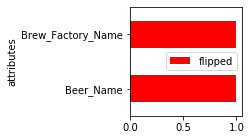

In [17]:
ax,negRank0 = aggregateRankings(neg_rankings0,positive=False,maxLenAttributes=1)

In [18]:
pos_rankings0,pos_triangles0,flippedPredictions_pos0= explainSamples(
    correctPredictions0,[tableA,tableB]
    ,standard_model,originalClass=1,maxLenAttributeSet=4)

100%|██████████| 38/38 [00:45<00:00,  1.19s/it]


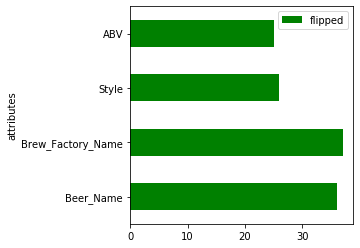

In [19]:
ax,posRank0 = aggregateRankings(pos_rankings0,positive=True,maxLenAttributes=1)

### Mine patterns

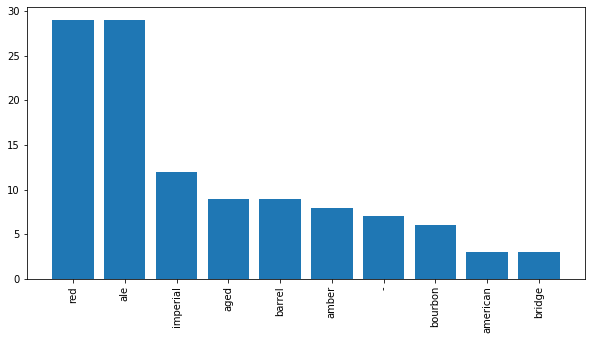

In [50]:
plotMostFrequentTokens(flippedPredictions_pos0,('Beer_Name',),10)

## RNN Model

In [29]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('models/beer_rnn.pth')
rnn_model = rnn_model.to('cuda')

In [34]:
predictions_rnn0 = wrapDm(augmented_test,rnn_model,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = augmented_test[(predictions_rnn0[:,1]>=0.5)& (augmented_test['label'] == 1)]
tn_group = augmented_test[(predictions_rnn0[:,0] >=0.5)& (augmented_test['label']==0)]
correctPredictions_rnn0 = pd.concat([tp_group,tn_group])

In [35]:
neg_rankings_rnn0,neg_triangles_rnn0,flippedPredictions_rnn_neg0 = explainSamples(
    correctPredictions_rnn0,[tableA,tableB],rnn_model,
    originalClass=0,maxLenAttributeSet=4)

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


In [36]:
pos_rankings0_rnn,pos_triangles0_rnn,flippedPredictions_pos0_rnn= explainSamples(
    correctPredictions_rnn0,[tableA,tableB]
    ,rnn_model,originalClass=1,maxLenAttributeSet=4)

100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


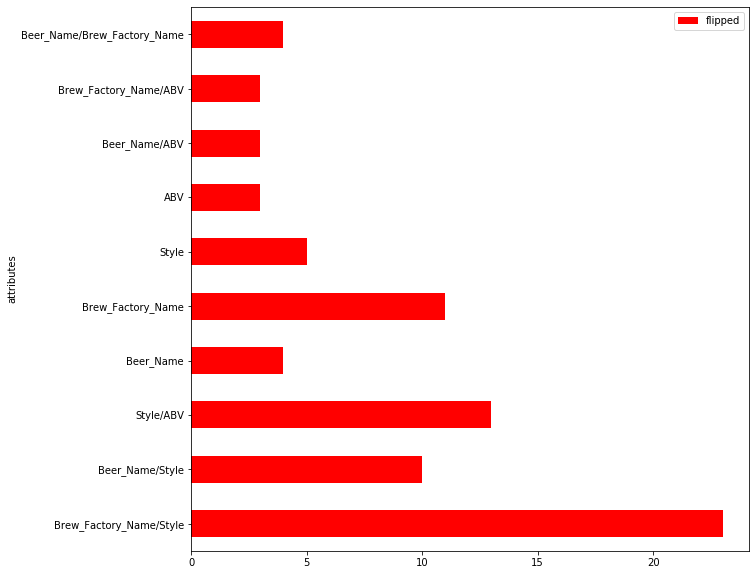

In [37]:
plt,negRanking0_rnn =aggregateRankings(neg_rankings_rnn0,positive=False,maxLenAttributes=2)

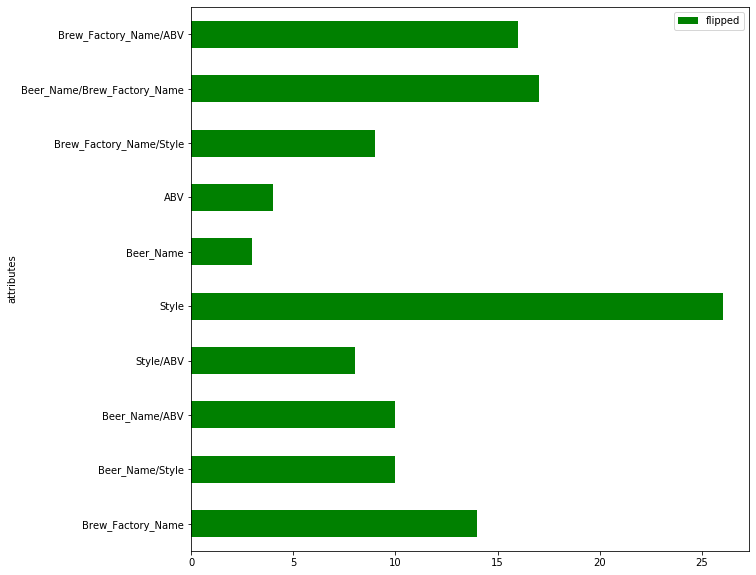

In [38]:
plt,posRanking0_rnn =aggregateRankings(pos_rankings0_rnn,positive=True,maxLenAttributes=2)

### Mine patterns

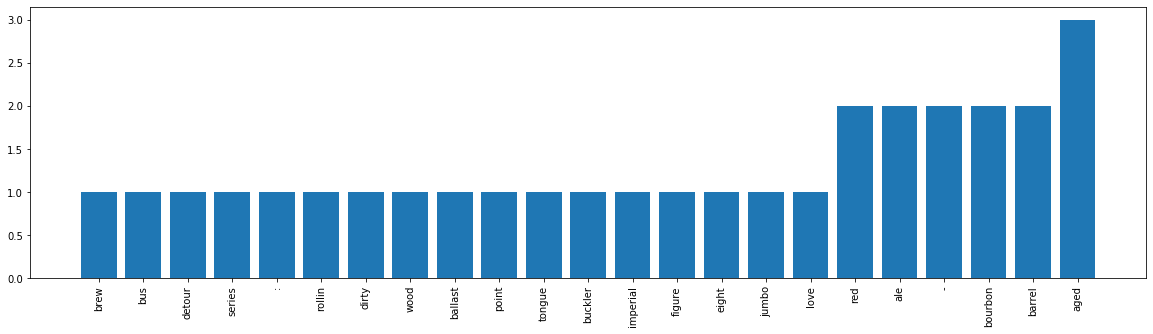

In [40]:
import matplotlib.pyplot as plt
import numpy as np
df = flippedPredictions_pos0_rnn[flippedPredictions_pos0_rnn.alteredAttribute==('Beer_Name',)]
D = countTokens(df.rtable_Beer_Name.values)
fig, ax = plt.subplots(figsize=(20,5))
x = list(D.keys())
y = list(D.values())
ax.bar(x,y,align='center')
plt.xticks(np.arange(len(x)),x, rotation='vertical')
plt.show()

## Retrain

In [74]:
train,validation,test = dm.data.process(ITUNES_DIR,train='improvedTrain1.csv',validation='valid_withid.csv',
                                       test='test_withid.csv',left_prefix='ltable_',right_prefix='rtable_',
                                        cache='impr.pth',ignore_columns=['ltable_id','rtable_id'])


Reading and processing data from "datasets/Structured/itunes-amazon/improvedTrain1.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/valid_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/test_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [75]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.run_train(train,validation,pos_neg_ratio=5,
                      batch_size=16,epochs=25,best_save_path='itunesamazon_impr.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 1 || Run Time:   11.0 | Load Time:    2.2 || F1:  44.71 | Prec:  29.97 | Rec:  87.96 || Ex/s:  30.40

===>  EVAL Epoch 1


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 1 || Run Time:    1.0 | Load Time:    0.5 || F1:  54.74 | Prec:  38.24 | Rec:  96.30 || Ex/s:  73.57

* Best F1: tensor(54.7368, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 2 || Run Time:   11.7 | Load Time:    2.4 || F1:  54.79 | Prec:  38.91 | Rec:  92.59 || Ex/s:  28.56

===>  EVAL Epoch 2


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 2 || Run Time:    1.0 | Load Time:    0.5 || F1:  65.00 | Prec:  49.06 | Rec:  96.30 || Ex/s:  72.26

* Best F1: tensor(65., device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 3 || Run Time:   11.3 | Load Time:    2.3 || F1:  66.46 | Prec:  50.24 | Rec:  98.15 || Ex/s:  29.40

===>  EVAL Epoch 3


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 3 || Run Time:    1.0 | Load Time:    0.5 || F1:  72.22 | Prec:  57.78 | Rec:  96.30 || Ex/s:  71.88

* Best F1: tensor(72.2222, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 4 || Run Time:   11.5 | Load Time:    2.4 || F1:  81.82 | Prec:  69.23 | Rec: 100.00 || Ex/s:  28.85

===>  EVAL Epoch 4


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 4 || Run Time:    1.0 | Load Time:    0.5 || F1:  70.27 | Prec:  55.32 | Rec:  96.30 || Ex/s:  72.68

---------------------

===>  TRAIN Epoch 5


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 5 || Run Time:   11.2 | Load Time:    2.3 || F1:  95.15 | Prec:  90.76 | Rec: 100.00 || Ex/s:  29.67

===>  EVAL Epoch 5


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 5 || Run Time:    1.0 | Load Time:    0.5 || F1:  76.19 | Prec:  66.67 | Rec:  88.89 || Ex/s:  72.76

* Best F1: tensor(76.1905, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 6 || Run Time:   11.3 | Load Time:    2.3 || F1:  95.58 | Prec:  91.53 | Rec: 100.00 || Ex/s:  29.45

===>  EVAL Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 6 || Run Time:    1.0 | Load Time:    0.5 || F1:  72.00 | Prec:  56.25 | Rec: 100.00 || Ex/s:  71.66

---------------------

===>  TRAIN Epoch 7


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 7 || Run Time:   11.0 | Load Time:    2.2 || F1:  99.08 | Prec:  98.18 | Rec: 100.00 || Ex/s:  30.41

===>  EVAL Epoch 7


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 7 || Run Time:    1.0 | Load Time:    0.5 || F1:  84.75 | Prec:  78.12 | Rec:  92.59 || Ex/s:  72.26

* Best F1: tensor(84.7458, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 8 || Run Time:   11.5 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.86

===>  EVAL Epoch 8


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 8 || Run Time:    1.0 | Load Time:    0.5 || F1:  85.25 | Prec:  76.47 | Rec:  96.30 || Ex/s:  72.01

* Best F1: tensor(85.2459, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 9 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.50

===>  EVAL Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 9 || Run Time:    1.0 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  74.11

---------------------

===>  TRAIN Epoch 10


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 10 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.56

===>  EVAL Epoch 10


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 10 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  73.15

---------------------

===>  TRAIN Epoch 11


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 11 || Run Time:   10.8 | Load Time:    2.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  30.87

===>  EVAL Epoch 11


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 11 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  74.13

---------------------

===>  TRAIN Epoch 12


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 12 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.56

===>  EVAL Epoch 12


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 12 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  72.86

---------------------

===>  TRAIN Epoch 13


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 13 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.48

===>  EVAL Epoch 13


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 13 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.34

---------------------

===>  TRAIN Epoch 14


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 14 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.70

===>  EVAL Epoch 14


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 14 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.41

---------------------

===>  TRAIN Epoch 15


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 15 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.82

===>  EVAL Epoch 15


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 15 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.96

---------------------

===>  TRAIN Epoch 16


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 16 || Run Time:   11.6 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.71

===>  EVAL Epoch 16


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 16 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.28

---------------------

===>  TRAIN Epoch 17


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 17 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.83

===>  EVAL Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 17 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.14

---------------------

===>  TRAIN Epoch 18


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 18 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.65

===>  EVAL Epoch 18


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 18 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.48

---------------------

===>  TRAIN Epoch 19


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 19 || Run Time:   11.5 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.98

===>  EVAL Epoch 19


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 19 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.35

---------------------

===>  TRAIN Epoch 20


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 20 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.47

===>  EVAL Epoch 20


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 20 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.38

---------------------

===>  TRAIN Epoch 21


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 21 || Run Time:   11.3 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.43

===>  EVAL Epoch 21


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 21 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.69

---------------------

===>  TRAIN Epoch 22


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 22 || Run Time:   11.6 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.74

===>  EVAL Epoch 22


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 22 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.17

---------------------

===>  TRAIN Epoch 23


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 23 || Run Time:   11.6 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.74

===>  EVAL Epoch 23


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 23 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.59

---------------------

===>  TRAIN Epoch 24


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


Finished Epoch 24 || Run Time:   11.7 | Load Time:    2.4 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  28.62

===>  EVAL Epoch 24


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 24 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  71.42

---------------------

===>  TRAIN Epoch 25


0% [█████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Finished Epoch 25 || Run Time:   11.4 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  29.13

===>  EVAL Epoch 25


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Finished Epoch 25 || Run Time:    1.0 | Load Time:    0.5 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  70.78

---------------------

Loading best model...
Training done.


tensor(85.2459, device='cuda:0')

In [76]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.6 | Load Time:    0.6 || F1:  86.21 | Prec:  80.65 | Rec:  92.59 || Ex/s:  91.97



tensor(86.2069, device='cuda:0')

In [77]:
standard_test = pd.read_csv(ITUNES_DIR+'merged_test.csv')
getMeanConfidenceAndVariance(hybrid_model,standard_test)

(0.7903955578804016, 0.011770060641655073)

### Evaluate first retrain

In [9]:
retrained1 = dm.MatchingModel(attr_summarizer='hybrid')
retrained1.load_state('models/beer_improved_hybrid.pth')
retrained1 = retrained1.to('cuda')

In [21]:
augmented_test = pd.read_csv(DATASET_DIR+'augmented_test.csv')

In [22]:
predictions1 = wrapDm(augmented_test,retrained1,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = augmented_test[(predictions1[:,1]>=0.5)& (augmented_test['label'] == 1)]
tn_group = augmented_test[(predictions1[:,0] >=0.5)& (augmented_test['label']==0)]
correctPredictions1 = pd.concat([tp_group,tn_group])

In [23]:
neg_rankings1,neg_triangles1,flipped_neg1 = explainSamples(
    correctPredictions1,[tableA,tableB],
    retrained1,originalClass=0,maxLenAttributeSet=4)

100%|██████████| 46/46 [00:56<00:00,  1.22s/it]


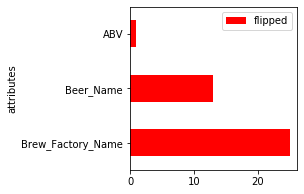

In [24]:
ax,negRank1  = aggregateRankings(neg_rankings1,positive=False,maxLenAttributes=1)

In [25]:
pos_rankings1,pos_triangles1,flipped_pos1 = explainSamples(
    correctPredictions1,[tableA,tableB]
    ,retrained1,originalClass=1,maxLenAttributeSet=4)

100%|██████████| 46/46 [00:56<00:00,  1.24s/it]


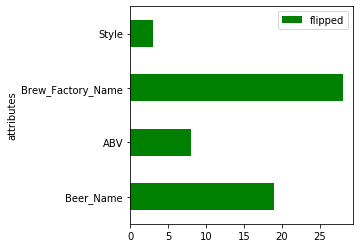

In [26]:
ax,posRank1 = aggregateRankings(pos_rankings1,positive=True,maxLenAttributes=1)

### Analyze patterns

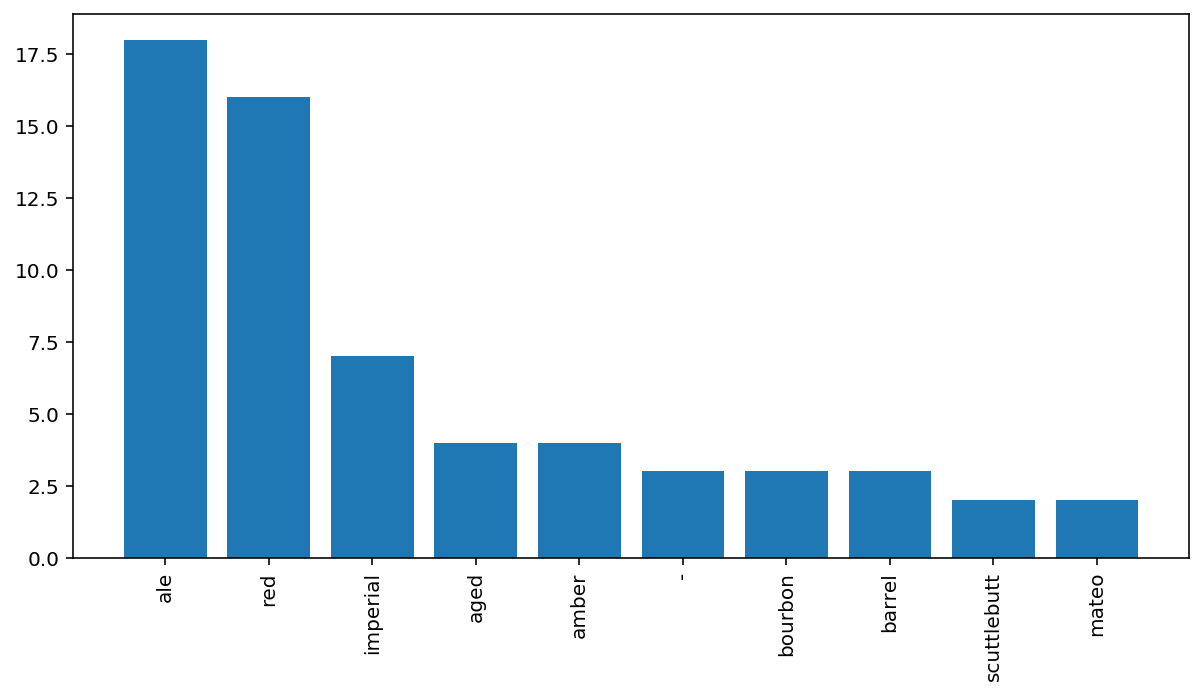

In [56]:
plotMostFrequentTokens(flipped_pos1,('Beer_Name',),10,'img1.png')

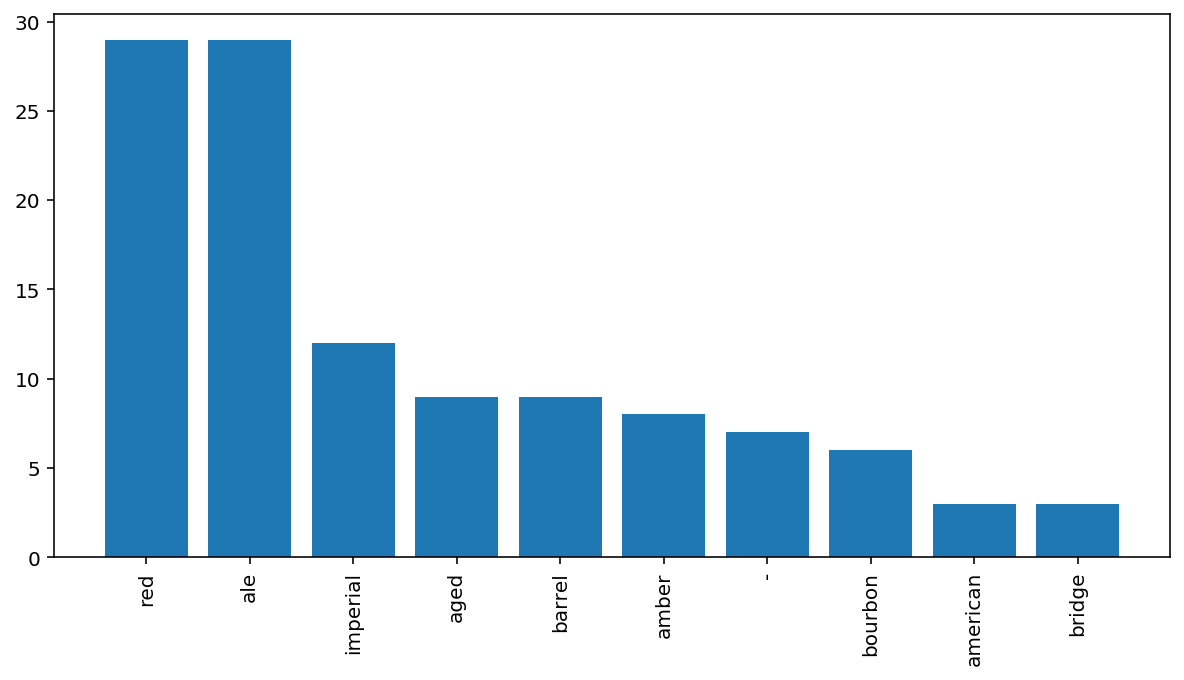

In [57]:
plotMostFrequentTokens(flippedPredictions_pos0,('Beer_Name',),10,'img2.png')

In [59]:
from utils.trianglesChart import countTokens
df0 = flippedPredictions_pos0[flippedPredictions_pos0.alteredAttributes==('Beer_Name',)]
df1 = flipped_pos1[flipped_pos1.alteredAttributes==('Beer_Name',)]
r0_neg = countTokens(df0.rtable_Beer_Name.values)
r1_neg = countTokens(df1.rtable_Beer_Name.values)

In [63]:
def compareRankings(r0,r1,topn):
    index= list(r0.keys())[0:topn]
    l0 = []
    l1 = []
    for token in index:
        l0.append(r0[token])
        if token in r1:
            l1.append(r1[token])
        else:
            l1.append(0)
    df = pd.DataFrame({'standard': l0,
                   'improved': l1}, index=index)
    return df

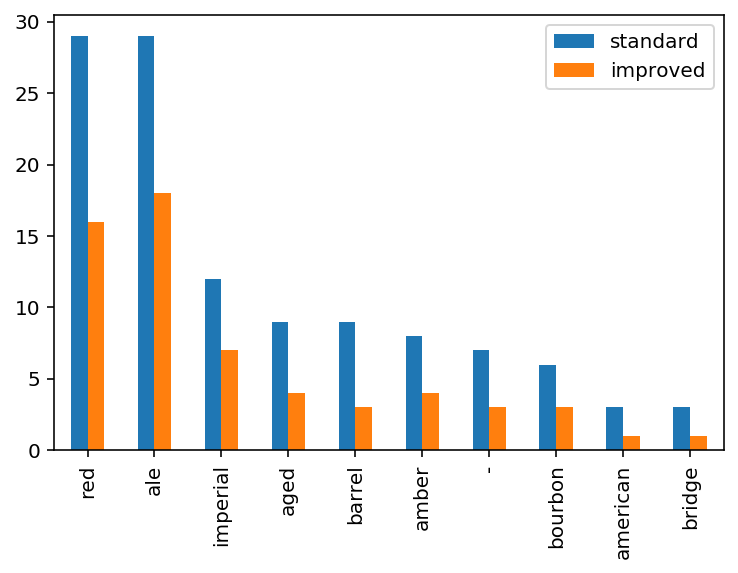

In [70]:
df = compareRankings(r0_neg,r1_neg,10)
plt = df.plot.bar(rot=90)
##fig = plt.get_figure()
##fig.savefig('beer_ranking_compar.pdf')

## Test bias

In [16]:
positives = pd.read_csv(DATASET_DIR+'positives.csv')
len(positives)

68

In [17]:
standard_pred = wrapDm(positives,standard_model)

In [18]:
positives['ltable_Beer_Name'] = positives['ltable_Beer_Name']+'imperial red ale'
positives['rtable_Beer_Name'] = positives['rtable_Beer_Name']+'imperial red ale'

In [19]:
bias_pred = wrapDm(positives,standard_model)
unique,counts = np.unique(np.argmax(bias_pred,axis=1),return_counts=True)
unique,counts

(array([0, 1]), array([43, 25]))

In [20]:
improved_pred = wrapDm(positives,retrained1)
unique,counts = np.unique(np.argmax(improved_pred,axis=1),return_counts=True)
unique,counts

(array([0, 1]), array([12, 56]))

In [108]:
negatives = test_df[test_df.label==0].copy()

In [100]:
def dropTokens(attr,tokensToDrop=['imperial','red','ale']):
    newAttr = [s.lower() for s in attr.split() if s.lower() not in tokensToDrop]
    return " ".join(newAttr)

In [114]:
negatives['ltable_Beer_Name'] = negatives['ltable_Beer_Name'].apply(dropTokens)
negatives['rtable_Beer_Name'] = negatives['rtable_Beer_Name'].apply(dropTokens)

In [115]:
negPred = wrapDm(negatives,standard_model)
unique,counts = np.unique(np.argmax(negPred,axis=1),return_counts=True)
unique,counts

(array([0, 1]), array([16, 61]))

In [116]:
negPred_improved = wrapDm(negatives,retrained1)
unique,counts = np.unique(np.argmax(negPred_improved,axis=1),return_counts=True)
unique,counts

(array([0, 1]), array([19, 58]))